<a href="https://colab.research.google.com/github/mwithgod3952/Machine_Learning_Theory_jh/blob/master/Kalman_Filter_for_Time_Series_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
from google.colab import drive
drive.mount("/content.drive/")

Drive already mounted at /content.drive/; to attempt to forcibly remount, call drive.mount("/content.drive/", force_remount=True).


In [32]:
import pandas as pd
import matplotlib.pyplot as plt

In [48]:
url = "https://raw.githubusercontent.com/herzog-ch/stock-prediction-using-kalman-in-python/master/data/IFNNY.csv"
df = pd.read_csv(url, index_col=0)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-29,10.620000,10.740000,10.610000,10.710000,9.922544,12300
2014-09-30,10.260000,10.320000,10.210000,10.300000,9.542690,20300
2014-10-01,10.070000,10.070000,10.000000,10.050000,9.311070,24400
2014-10-02,10.020000,10.020000,9.850000,9.920000,9.190628,29100
2014-10-03,9.920000,9.950000,9.870000,9.940000,9.209157,24400
...,...,...,...,...,...,...
2019-09-23,18.620001,18.780001,18.559999,18.700001,18.700001,241600
2019-09-24,18.760000,18.790001,18.459999,18.520000,18.520000,227200
2019-09-25,18.250000,18.440001,18.110001,18.410000,18.410000,245200


In [49]:
df.shape

(1259, 6)

In [50]:
df.index = (pd.to_datetime(df.index))
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

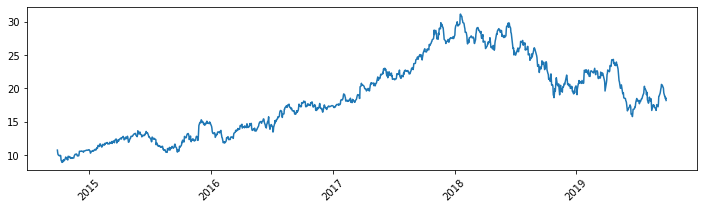

In [52]:
plt.figure(figsize=(12, 3))

plt.plot(df.iloc[:,1])
plt.xticks(rotation=45)
plt.show()

In [53]:
import numpy as np
from collections import namedtuple

State = namedtuple('State', 'X, P')


def predict(state, F, Q):
    """Perform the predict step
    x_pred = Fx
    P_pred = F P F^T + Q
    :param state: State namedtuple
    :param F: Transition matrix
    :param Q: Process Covariance
    :return: The prior as a State namedtuple
    """

    assert state.X.shape[0] == F.shape[1]
    assert state.X.shape[1] == 1
    assert F.shape[0] == F.shape[1]
    assert Q.shape[0] == Q.shape[1]
    assert Q.shape[0] == F.shape[0]

    x_pred = np.matmul(F, state.X)
    p_pred = np.matmul(F, np.matmul(state.P, F.T)) + Q
    return State(x_pred, p_pred)


def update(prior, z, R, H):
    """Perform update step
    S = H P_prior H^T + R
    K = P_prior H^T S^-1
    y = z - H x_prior
    x = x_prior + Ky
    P = (I - KH) P_prior
    :param prior: State namedtuple holding the prior mean and covariance
    :param z: measurement vector
    :param R: measurement covariance matrix
    :param H: measurement matrix
    :return: Returns the posterior mean and covariance as State namedtuple
    """

    assert prior.X.shape[1] == 1
    assert prior.X.shape[0] == H.shape[1]
    assert H.shape[0] == z.shape[0]
    assert z.shape[1] == 1
    assert prior.P.shape[0] == prior.P.shape[1]
    assert prior.P.shape[1] == H.shape[1]

    z_pred = np.matmul(H, prior.X)
    y = z - z_pred
    S = np.matmul(H, np.matmul(prior.P, H.T)) + R
    K = np.matmul(prior.P, np.matmul(H.T, np.linalg.inv(S)))
    x_posterior = prior.X + np.matmul(K, y)
    p_posterior = np.matmul((np.identity(prior.P.shape[0]) - np.matmul(K, H)), prior.P)
    return State(x_posterior, p_posterior)

In [54]:
import numpy as np
import matplotlib.pyplot as plt


def main():

    # read data
    data_filename = '../data/IFNNY.csv'
    dataReader = yahoo_financedata.YahooFinanceData()
    dataReader.open_data(data_filename)

    # init kalman filter
    x = np.full((2, 1), 2)
    P = np.full((2, 2), 2 ** 2)
    state = kalman_filter.State(x, P)

    Q = np.full((2, 2), 1 ** 2)
    F = np.array([[1, 1],
                  [0, 1]])
    R = np.array([[0.5 ** 2]])
    H = np.array([[1, 0]])

    # data for plotting
    gt = {'price': [], 'trend': []}
    result = {'price': [], 'trend': []}
    velocity = []

    counter = 0

    while dataReader.has_more_data():
        z = dataReader.next_measurement()

        if counter == 0:
            x = np.array([[z[0][0]], [0]])
            state = kalman_filter.State(x, P)

        prior = kalman_filter.predict(state, F, Q)
        posterior = kalman_filter.update(prior, z, R, H)
        state = posterior

        gt['price'].append(z[0][0])
        result['price'].append(prior.X[0][0])
        velocity.append(prior.X[1][0])

        if counter == 0:
            gt['trend'].append(1)
            result['trend'].append(1)
        else:
            predicted_trend = 1 if prior.X[0][0] > result['price'][counter - 1] else -1
            result['trend'].append(predicted_trend)
            gt_trend = 1 if z[0][0] > gt['price'][counter - 1] else -1
            gt['trend'].append(gt_trend)

        counter += 1
        # if counter > 20:
        #    break

    # KPI
    # number of correct trend predictions
    correct_predictions = 0
    for x, y in zip(result['trend'], gt['trend']):
        if x == y:
            correct_predictions += 1
    print(correct_predictions)
    print(len(gt['trend']))
    print(float(correct_predictions) / len(gt['trend']))

    plt.figure(1)

    plt.plot(gt['price'])
    plt.plot(result['price'])
    plt.plot(velocity)

    x_axis = list(range(len(gt['trend'])))
    plt.scatter(x_axis, gt['trend'], marker='o', color='g')
    plt.scatter(x_axis, result['trend'], marker='x', color='r')

    plt.legend(['actual stock price', 'predicted stock price', 'actual trend', 'predicted trend', 'momentum'])

    plt.grid()
    plt.show()


if __name__ == '__main__':
    main()

ModuleNotFoundError: ignored